In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [3]:
import os
if not os.path.exists('birds21wi'):
    !mkdir birds21wi
    os.chdir('birds21wi')
    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')

--2021-03-16 14:29:25--  https://pjreddie.com/media/files/birds/train.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7970048512 (7.4G) [application/octet-stream]
Saving to: ‘train.tar’

train.tar           100%[===================>]   7.42G  51.7MB/s    in 2m 56s  

2021-03-16 14:32:22 (43.1 MB/s) - ‘train.tar’ saved [7970048512/7970048512]

--2021-03-16 14:32:22--  https://pjreddie.com/media/files/birds/test.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2057210880 (1.9G) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]   1.92G  28.6MB/s    in 65s     

2021-03-16 14:33:27 (30.1 MB/s) - ‘test.tar’ saved [2057210880/2057210880]

--2021-03-16 14:33:27--  https:

In [4]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(256, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.RandomRotation(30),
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [ ]:
print(data['to_class'])

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

torch.Size([8, 3, 256, 256])


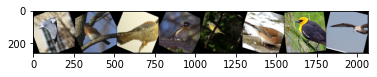

Labels:Ring-billed Gull (Adult), Eastern Bluebird, American Kestrel (Adult male), Black-headed Grosbeak (Female/immature male), Nashville Warbler, Dark-eyed Junco (Pink-sided), Yellow-headed Blackbird (Adult Male), Ring-billed Gull (Immature)


In [ ]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [5]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet101', pretrained=True)
resnet.fc = nn.Linear(2048, 555)

losses = train(resnet, data['train'], epochs=20, lr=.01, schedule={10: 0.001, 12: 0.0005, 17: 0.0001} ,print_every=10, checkpoint_path=checkpoints)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth



[0,    10] loss: 6.342
[0,    20] loss: 6.350
[0,    30] loss: 6.232
[0,    40] loss: 6.012
[0,    50] loss: 5.809
[0,    60] loss: 5.652
[0,    70] loss: 5.389
[0,    80] loss: 5.189
[0,    90] loss: 5.002
[0,   100] loss: 4.710
[0,   110] loss: 4.586
[0,   120] loss: 4.376
[0,   130] loss: 4.245
[0,   140] loss: 4.059
[0,   150] loss: 4.008
[0,   160] loss: 3.958
[0,   170] loss: 3.762
[0,   180] loss: 3.658
[0,   190] loss: 3.569
[0,   200] loss: 3.479
[0,   210] loss: 3.460
[0,   220] loss: 3.349
[0,   230] loss: 3.174
[0,   240] loss: 3.132
[0,   250] loss: 3.044
[0,   260] loss: 2.922
[0,   270] loss: 2.936
[0,   280] loss: 2.833
[0,   290] loss: 2.876
[0,   300] loss: 2.922
[0,   310] loss: 2.704
[0,   320] loss: 2.700
[0,   330] loss: 2.646
[0,   340] loss: 2.611
[0,   350] loss: 2.546
[0,   360] loss: 2.550
[0,   370] loss: 2.471
[0,   380] loss: 2.514
[0,   390] loss: 2.511
[0,   400] loss: 2.255
[0,   410] loss: 2.359
[0,   420] loss: 2.344
[0,   430] loss: 2.392
[0,   440]

In [ ]:
def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')
plt.plot(smooth(losses,50))

In [ ]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
predict(resnet, data['test'], checkpoints + "preds.csv")

In [ ]:
!cp /content/drive/MyDrive/CSE_455_Project/utils.py .
!cp /content/drive/MyDrive/CSE_455_Project/BirdDataSet.py .
!cp /content/drive/MyDrive/CSE_455_Project/Simple_DLA.py .
from utils import *

In [ ]:
save_model(resnet, "Resnet50_lr0.01_0.001_0.0001_2_10epoch_linear_256", path="/content/")
with open('/content/loss_Resnet50_lr0.01_0.001_0.0001_2_10epoch_linear_256.csv', 'w') as writefile:
    writefile.write(", ".join([str(l) for l in losses]))